## Using RNNs to classify sentiment on IMDB data
For this exercise, we will train a "vanilla" RNN to predict the sentiment on IMDB reviews.  The data consists of 25000 training sequences and 25000 test sequences.  The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.

We will walk through the preparation of the data and the building of an RNN model.  Then it will be your turn to build your own models (and prepare the data how you see fit).

| Step | Description                                  |
| ---- | -------------------------------------------- |
| 1    | Load and preprocess the IMDB dataset         |
| 2    | Pad sequences                                |
| 3    | Visualize data samples                       |
| 4    | Build a simple RNN model                     |
| 5    | Train the model                              |
| 6    | Evaluate performance                         |
| 7    | Visualize training progress                  |
| 8    | Visualize how RNN works on a sample sequence |


#### 1. Load and preprocess IMDB dataset and sample plotting

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Hyperparameters
num_words = 10000
maxlen = 300  # Increased length to capture more context
embedding_dim = 64
rnn_units = 64
batch_size = 64
epochs = 10

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print(f"Train sequences: {len(x_train)}, Test sequences: {len(x_test)}")
print(f"Example review (encoded): {x_train[0][:10]}")
print(f"Sentiment: {y_train[0]}")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train sequences: 25000, Test sequences: 25000
Example review (encoded): [0 0 0 0 0 0 0 0 0 0]
Sentiment: 1


In [2]:
# Load word index and prepare reverse lookup
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"

# Decode function
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

# Pick a sample
sample_id = 100
print(" Sample Review (encoded):", x_train[sample_id][:10], "...")  # Truncated view
print("\n Decoded Review Text:\n")
print(decode_review(x_train[sample_id]))

# Sentiment label
print("\n Sentiment:", "Positive 😊" if y_train[sample_id] == 1 else "Negative 😞")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 Sample Review (encoded): [0 0 0 0 0 0 0 0 0 0] ...

 Decoded Review Text:

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> i am a great fa

#### 2. Pad Sequences to Same Length

In [3]:
maxlen = 200  # Cut off reviews after 200 words
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

print(f"Padded review shape: {x_train.shape}")

Padded review shape: (25000, 200)


#### 3. Visualize Word Distribution and a Sample Review

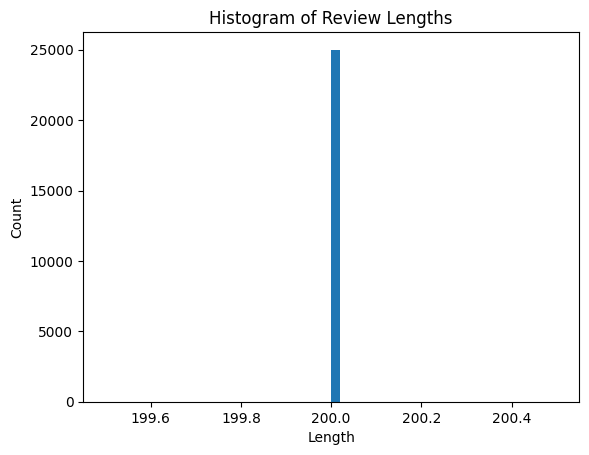


Decoded review:

and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life 

In [4]:
# Histogram of review lengths before padding
review_lengths = [len(seq) for seq in x_train]
plt.hist(review_lengths, bins=50)
plt.title("Histogram of Review Lengths")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

# Decode a sample review
word_index = imdb.get_word_index()
reverse_word_index = {value+3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

print("\nDecoded review:\n")
print(decode_review(x_train[0]))


#### 4. Build a Simple Vanilla RNN

In [11]:

# Build model
model = Sequential([
    Embedding(num_words, embedding_dim, input_length=maxlen),
    SimpleRNN(32, return_sequences=False, dropout=0.05),  # Vanilla RNN
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 5. Train the model

In [12]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5470 - loss: 0.6716 - val_accuracy: 0.8260 - val_loss: 0.3949
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.8549 - loss: 0.3524 - val_accuracy: 0.8562 - val_loss: 0.3383
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9229 - loss: 0.2102 - val_accuracy: 0.8462 - val_loss: 0.3951
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9576 - loss: 0.1288 - val_accuracy: 0.8340 - val_loss: 0.4597


#### 6. Evaluate on test set

In [13]:
# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8567 - loss: 0.3381

Final Test Accuracy: 0.8586


#### 7. Visualize training process

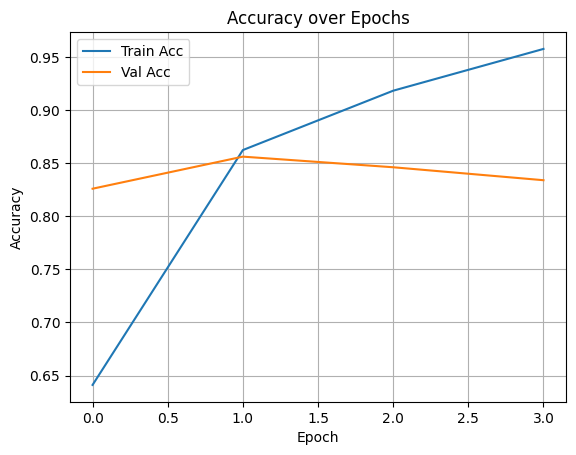

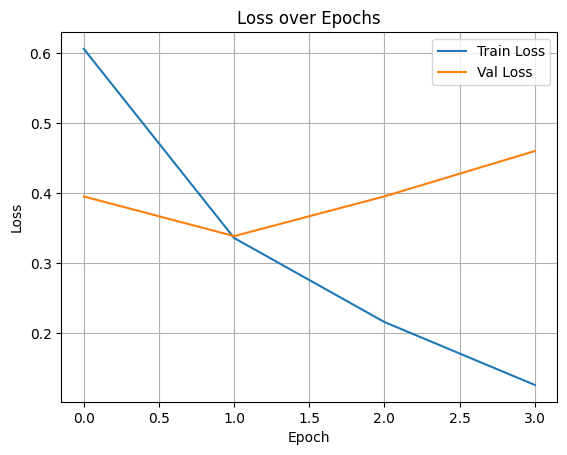

In [14]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### 8. Visualize How RNN Works

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


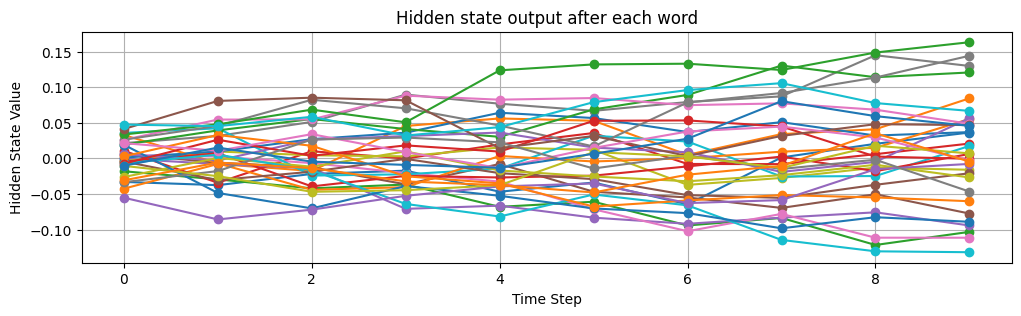

In [15]:
# Visualize how an RNN processes a short sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_rnn_steps(sequence, hidden_states):
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(hidden_states, marker='o')
    ax.set_title("Hidden state output after each word")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Hidden State Value")
    ax.grid(True)
    plt.show()

# Select a short example
short_seq = x_test[0][:10].reshape(1, 10)

# Build a new model for this
rnn_step_model = Sequential([
    Embedding(input_dim=num_words, output_dim=32, input_length=10),
    SimpleRNN(32, return_sequences=True),  # We need the hidden states for each step
])
output = rnn_step_model.predict(short_seq)

plot_rnn_steps(short_seq.flatten(), output[0])


## Title: "Hidden state output after each word"
This plot visualizes the internal behavior of a Vanilla RNN as it processes each word in a sequence (like a movie review from the IMDB dataset).

Y-axis: Hidden State Value
Each RNN cell has a hidden state vector of size n (in your earlier code, it was 32).

The values on the y-axis represent the activation values (output of tanh, usually between -1 and 1) of these hidden units after each word is processed.

X-axis: Time Step
Each tick (0 to 9) represents a word position in the input sequence.

For example, Time Step 0 corresponds to the first word, Time Step 1 to the second word, and so on — here for a sequence of length 10.

Colored Lines
Each line corresponds to one hidden state unit (out of 32).

The line shows how that specific unit's value evolves over the sequence.

Some activations grow, others shrink, and some oscillate — showing how the RNN "remembers" or "forgets" information over time.

Explaination:
This is a window into the RNN’s "memory".

"Each colored line is like a neuron that's paying attention to different patterns in the input. Some might care about certain words. Some might spike when they see sentiment-rich words like great, awful, or not. The graph shows how these internal signals change word by word."



### Using LSTM to classify sentiment on IMDB data

#### 1. Load and Prepare data

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Only keep the top 10,000 words
num_words = 10000
maxlen = 200  # Limit review length to 200

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Pad sequences to the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


#### 2. Build the LSTM model

In [25]:
model_lstm = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

model_lstm.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 3. Train the model

In [ ]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
158/313 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - accuracy: 0.5644 - loss: 0.6615

#### 4. Evaluate and Compare

In [ ]:
test_loss, test_acc = model_lstm.evaluate(x_test, y_test)
print(f"LSTM Test Accuracy: {test_acc:.4f}")

#### 5. Visulize the training of LSTM

In [ ]:
# Accuracy
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Using GRU to classify sentiment on IMDB data¶

#### 1. Load and Preprocess the IMDB Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 10000
maxlen = 200

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

#### 2. Build GRU Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=32, input_length=maxlen),
    GRU(32),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 3. Train the model

In [ ]:
history_gru = model_gru.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.6182 - loss: 0.6273 - val_accuracy: 0.8282 - val_loss: 0.3857
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.8767 - loss: 0.3039 - val_accuracy: 0.8424 - val_loss: 0.3655
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.9121 - loss: 0.2300 - val_accuracy: 0.8498 - val_loss: 0.3701
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9367 - loss: 0.1818 - val_accuracy: 0.8424 - val_loss: 0.3823
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9451 - loss: 0.1635 - val_accuracy: 0.8582 - val_loss: 0.3721


#### 4. Evaluate the GRU model

In [ ]:
test_loss, test_acc = model_gru.evaluate(x_test, y_test)
print(f"GRU Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.8513 - loss: 0.4006
GRU Test Accuracy: 0.8528


#### 5. Visulize the training process

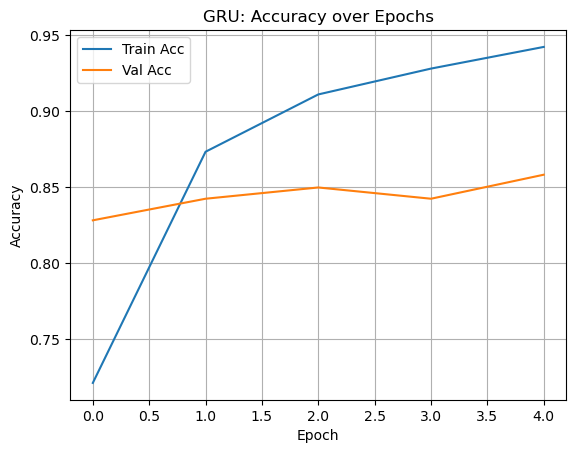

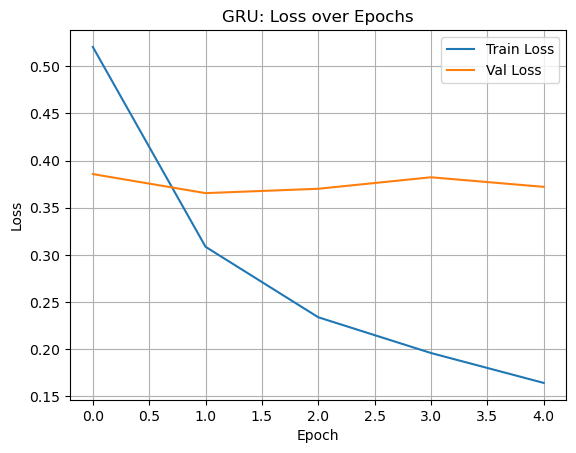

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_gru.history['accuracy'], label='Train Acc')
plt.plot(history_gru.history['val_accuracy'], label='Val Acc')
plt.title('GRU: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Analogy    
- "RNN is like a goldfish—short memory.
- LSTM is like a careful librarian—checks everything before forgetting.
- GRU is a smart assistant—remembers just enough without too much overhead."

#### Basic Comparision

In [ ]:
decode_review(x_test[100])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> a quick glance at the premise of this film would seem to indicate just another dumb <UNK> <UNK> <UNK> slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread <UNK> tension amidst a lovely <UNK> backdrop these feelings are further <UNK> by a cast of realistically likable characters and <UNK> that are more amoral than cardboard <UNK> of evil oh yeah george kennedy is

In [ ]:
# Predict sentiment on one review
sample = x_test[100].reshape(1, -1)

pred_rnn = model.predict(sample)[0][0]
pred_lstm = model_lstm.predict(sample)[0][0]
pred_gru = model_gru.predict(sample)[0][0]

print(f"RNN Prediction: {pred_rnn:.4f}")
print(f"LSTM Prediction: {pred_lstm:.4f}")
print(f"GRU Prediction: {pred_gru:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
RNN Prediction: 0.0392
LSTM Prediction: 0.0643
GRU Prediction: 0.1280
